# Replication Notebook of Jeppe Druedahl (2021): A Guide on Solving Non-convex Consumption-Saving Models

### Author: Adrian Monninger

This notebook replicates a consumption-savings problem with non-durable and durable consumption subject to adjustment costs solved with the nested endogeneous grid method by Druedahl (2021). The only difference is that the original code has persistent income as an additional state variable while this example uses only variables normalized by permanent income.

I will start specifying the problem, show results of the original code, and provide code examples how the newly created `DurableConsumerType` in econ-ark can be used. Afterwards, I compare it with the `IndShockConsumerType` and show some bottleneck cases of the code.

## The DurableConsumerType
The `DurableConsumerType` inherits many attributes from the `IndShockConsumerType`. The only difference is that a durable good provides a flow of consumption services which enter the utility function as well. Hence, each household has the utility function:
\begin{align}
    u(c_t, d_t) &= \frac{(c_t^\alpha (d_t + \underline{d})^{1 - \alpha})^{1 - \rho}}{1 - \rho}
\end{align}
Where $c_t$, and $d_t$ is the non-durable and durable consumption, $\rho$ is the coefficient of relative risk aversion, and $\alpha$ is the Cobb-Douglas parameter.

Each period, the household can adjust the stock of durable goods $n_t$ which incurs a proportional adjustment cost $\tau \in (0,1)$. Hence, in case of adjustment, the cash-on-hand after selling the beginning-of-period stock of durables is: $x_t = m_t + (1 - \tau)n_t$ which then can be saved or used to purchase durables and non-durables.

Therefore, the household's end of period assets $a_t = x_t - c_t - d_t$. The consumer cannot borrow $a_t \geq 0$ and he interest rateis $r$. Hence, next-period cash-on-hand is
\begin{align}
    m_{t+1} &= Ra_t + y_{t+1}
\end{align}

The durable stock depreciates each period with rate $\delta \in (0,1)$:
\begin{align}
    n_{t+1} = (1 - \delta)n_t
\end{align}

The Bellman Equation is given by the maximum over the value functions of keeping $d_t = n_t$, and adjusting $d_t \neq n_t$. Or:
\begin{align}
    v_t(n_t,m_t) &= \max_{c_t, d_t} \Big(v_t^{keep}(n_t,m_t), v_t^{adj}(n_t, m_t) \Big)\\
    & \text{s.t.}\\
    a_t &= x_t - c_t - d_t \geq 0 \\
    m_{t+1} &= Ra_t + y_{t+1}\\
    n_{t+1} &= (1 - \delta)n_t
\end{align}

Where we have the Bellman for the keeper:
\begin{align}
    v_t^{keep}(n_t,m_t) &= \max_{c_t} u(c_t,n_t) + \beta \mathbb{E}_t \Big(v_{t+1}(n_{t+1}, m_{t+1})\Big)\\
    & \text{s.t.}\\
    a_t &= m_t- c_t \geq 0 \\
    m_{t+1} &= Ra_t + y_{t+1}\\
    n_{t+1} &= (1 - \delta)n_t
\end{align}

And for the adjuster
\begin{align}
    v_t^{adj}(n_t,m_t) &= \max_{c_t,n_t} u(c_t,n_t) + \beta \mathbb{E}_t \Big(v_{t+1}(n_{t+1}, m_{t+1})\Big)\\
    & \text{s.t.}\\
    a_t &= x_t - c_t \geq 0 \\
    m_{t+1} &= Ra_t + y_{t+1}\\
    n_{t+1} &= (1 - \delta)n_t
\end{align}

### Implementation (nested endogeneous grid-method)
The nested endogeneous grid method takes advantage of the fact, that the post-decision value function is the same for adjuster and keeper:
\begin{align}
    w_t(d_t, a_t) = \beta E[v_{t+1} (n_{t+1}, m_{t+1})].
\end{align}
Hence, the keeper problem gets:
\begin{align}
    v_t^{keep}(n_t,m_t) &= \max_{c_t} u(c_t,n_t) + w_t(d_t, a_t)\\
    & \text{s.t.}\\
    a_t &= m_t- c_t \geq 0 \\
    m_{t+1} &= Ra_t + y_{t+1}\\
    n_{t+1} &= (1 - \delta)n_t
\end{align}
Where we maximize the value function for each combination of beginning-of-period durable stock ($n_t$), and market resources ($m_t)$. Additionally, when we think of the problem as sequential, meaning first the optimal durable consumption $d_t$ is determined, and then how much to consume and save, we can write:
\begin{align}
    v_t^{adj}(n_t,m_t) &= \max_{d_t} v_t^{keep}(n_t,m_t)\\
    & \text{s.t.}\\
    a_t &= x_t - c_t - d_t \geq 0 \\
    m_{t+1} &= Ra_t + y_{t+1}\\
    n_{t+1} &= (1 - \delta)n_t
\end{align}
Eg, optimize the value function of the keepers problem wrt $d_t$.

For the EGM part, we need the Euler equation:
\begin{align}
    u_c(c_t,n_t) &= \alpha c_t^{\alpha(1 - \rho) - 1} n_t^{(1 - \alpha)(1 - \rho)} = q_t
\end{align}
The idea is that we fix the end-of-perid asset state $a_t$ and then use the Euler-equation and the budget constraint to infer respectively the consumption choice $c_t$ and the level of cash-on-hand $m_t$.

Additionally, as we have a discrete choice, we need to apply an upper-envelope algorithm.This is necessary, as we have a discrete choice of adjusting or not-adjusting. Hence, we have a kink in the value function, meaning that for different values of $c_t$ and $d_t$, we get the same utility. Hence, the value function is not concave anymore! To deal with that, we use this algorithm which essentially gets rid of the parts of the value function which are decreasing.

### Implementation Steps:
1. Compute the post-decision functions $w_t$ and $q_t$ on a grid over the post-decision states $d_t, a_t$
2. Solve the keeper problem on a grid over the pre-decision states $n_t, m_t$ where the combined EGM and upper envelope is applied for each $n_t$
3. Solve the adjuster problem using interpolation of the keeper value function found in step 2.

### Original Source
Jeppe Druedahl published a notebook:
https://github.com/NumEconCopenhagen/ConsumptionSavingNotebooks 

#### Useful HARK notebooks:
1. Discrete choice (retirement decision)
https://github.com/econ-ark/EndogenousRetirement/blob/master/Endogenous-Retirement.ipynb
2. Upper Envelope Theorem
https://github.com/econ-ark/DemARK/blob/master/notebooks/DCEGM-Upper-Envelope.ipynb
3. How the IndShockConsumerType works 
https://github.com/econ-ark/HARK/blob/master/examples/HowWeSolveIndShockConsumerType/HowWeSolveIndShockConsumerType.ipynb


# 1. The original Code (with persistent income component)

In [1]:
# Installing necessary codes
!pip install EconModel
!pip install ConSav

In [2]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np

# load the DurableConsumptionModel module
from DurableConsumptionModel import DurableConsumptionModelClass

import numba as nb
nb.set_num_threads(8)

T = 5

In [3]:
start = time.time()

model_negm = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'negm','T':T,'do_print':True})
model_negm.precompile_numba() # solve with very coarse grids
model_negm.solve()

end = time.time()
time_original = end - start
print("time used: ", time_original, " seconds")

numba precompiled in 62.9 secs
 t = 4 solved in 0.0 secs
  w computed in 0.2 secs
  solved keeper problem in 0.0 secs
  solved adjuster problem in 0.0 secs
 t = 3 solved in 0.3 secs
  w computed in 0.2 secs
  solved keeper problem in 0.0 secs
  solved adjuster problem in 0.0 secs
 t = 2 solved in 0.5 secs
  w computed in 0.2 secs
  solved keeper problem in 0.0 secs
  solved adjuster problem in 0.0 secs
 t = 1 solved in 0.8 secs
  w computed in 0.2 secs
  solved keeper problem in 0.0 secs
  solved adjuster problem in 0.0 secs
 t = 0 solved in 1.0 secs
time used:  63.912301540374756  seconds


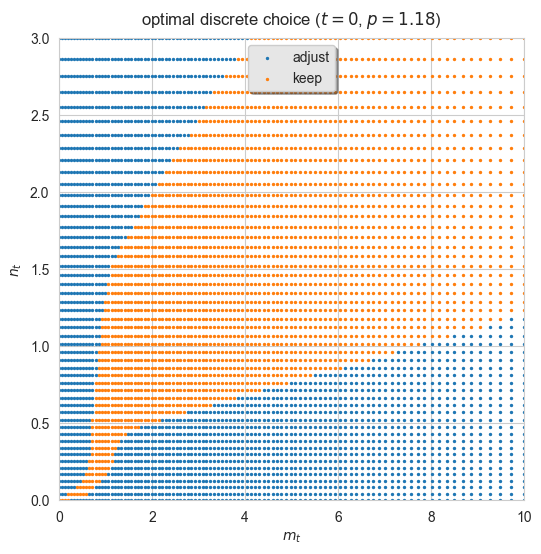

interactive(children=(Dropdown(description='t', options=(0, 1, 2, 3, 4), value=0), Dropdown(description='ip', …

In [4]:
model_negm.decision_functions()

# 2. The normalized version
As all HARK models are normalized by permanent income and do not have a persistent component, I tranfrom the code such that we only have two state variables: durable stock (n) and market resources (m).

In the code example, it is not a problem as the original has a persistent factor of one, but allows for other values. Thus, we get the same picture, with one state variable less.

In [5]:
from DurableConsumptionModel_NrM import DurableConsumptionModelClass_NrM

In [6]:
start = time.time()
model_negm_NrM = DurableConsumptionModelClass_NrM(name='example_negm_NrM',par={'solmethod':'negm','T':T,'do_print':True})
model_negm_NrM.precompile_numba() # solve with very coarse grids
model_negm_NrM.solve()
# model_negm_NrM.simulate()
# model_negm_NrM.save()

end = time.time()
time_NrM = end - start
print("time used: ", time_NrM, " seconds")

time used:  20.024160385131836  seconds


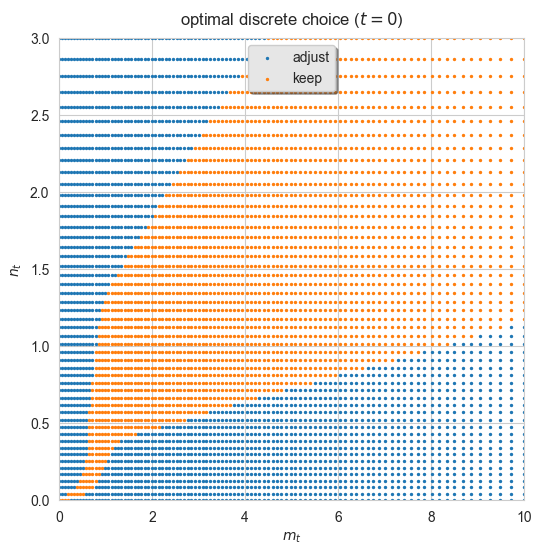

interactive(children=(Dropdown(description='t', options=(0, 1, 2, 3, 4), value=0), Dropdown(description='name'…

In [7]:
model_negm_NrM.decision_functions()

# 3. HARK Version `DurableConsumerType`
Now, we use the `DurableConsumerType` and compare solutions.

In [8]:
### Import
import numpy as np
from DurableModel import DurableConsumerType, decision_function
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType, init_idiosyncratic_shocks
import time # to time

import matplotlib.pyplot as plt

As always, we create a dictionary with initial values. Note that we have to specify additional variables such as `alpha`, `dDepr`, or `adjC`.

In [9]:
init_durable = dict(
    init_idiosyncratic_shocks,
    **{
        "alpha": 1.0, # Cobb-Douglas parameter for non-durable good consumption in utility function
        "dDepr": 1, # Depreciation Rate of Durable Stock
        "adjC": 0, # Adjustment costs
        "d_ubar": 0, # Minimum durable stock for utility function
        # For Grids
        "nNrmMin": 0.0,
        "nNrmMax": 3, #5,
        "nNrmCount": 50,
        "mNrmMin": 0.0,
        "mNrmMax": 10,
        "mNrmCount": 100,
        "xNrmMin": 0.0,
        "xNrmMax": 13, #10,  # xMax = mNrmMax + (1 - adjC)* nNrmMax
        "xNrmCount": 100,
        "aNrmMin": 0.0,
        "aNrmMax": 11,  #xNrmMax+1.0
        "aNrmCount": 100,
        ### No income shocks
        "PermGroFac": [1.0, 1.0, 1.0, 1.0],# 1.0],
        "PermShkCount": 7,
        "PermShkStd": [0.0, 0.0, 0.0, 0.0], #, 0.0, 0.0, 0.0],
        "TranShkStd": [0.0, 0.0, 0.0, 0.0], #, 0.0, 0.0, 0.0],
        "UnempPrb": 0.0,
        "UnempPrbRet": 0.0,
        "LivPrb": [1.0, 1.0, 1.0, 1.0], #, 1.0, 1.0, 1.0],
        ### For simulation
        "T_sim": 4,
        "AgentCount": 10,
        ### Others
        "BoroCnstArt": 0,
        "BoroCnstdNrm": 0, # Borrowing Constraint of durable goods.
        "cycles": 1,
        "T_cycle": 4,
        "tol": 1e-08,
        # To construct grids differently
        "NestFac": 3, 
        "grid_type": 'nonlinear',
    }
)

In [10]:
### Solve and time
start = time.time()
DurableReplication = DurableConsumerType(**init_durable)
DurableReplication.alpha = 0.9
DurableReplication.DiscFac = 0.965
DurableReplication.CRRA = 2
DurableReplication.d_ubar = 1e-2
DurableReplication.Rfree = 1.03
DurableReplication.adjC = 0.10
DurableReplication.dDepr = 0.15
DurableReplication.nNrmCount = 50
DurableReplication.nNrmMax = 3.0
DurableReplication.mNrmCount = 100
DurableReplication.mNrmMax = 10.0
DurableReplication.xNrmCount = 100
DurableReplication.xNrmMax = 13.0
DurableReplication.aNrmCount = 100
DurableReplication.aNrmMax = 11.0
DurableReplication.PermShkStd = [0.1, 0.1, 0.1, 0.1]
DurableReplication.TranShkStd = [0.1, 0.1, 0.1, 0.1]

DurableReplication.update_income_process()
DurableReplication.solve()#(verbose=False)
end = time.time()
time_HARK = end - start
print("time used: ", time_HARK, " seconds")

time used:  11.5862877368927  seconds


In [11]:
# Compare speeds:
print("Using the same number of gridpoints for each grid: 100, the speed improvements are:")
print("Original: ", time_original)
print("Normalized Version: ", time_NrM)
print("HARK Version: ", time_HARK)

Using the same number of gridpoints for each grid: 100, the speed improvements are:
Original:  63.912301540374756
Normalized Version:  20.024160385131836
HARK Version:  11.5862877368927


In [12]:
### What is saved:
print(vars(DurableReplication.solution[0]))

{'cFunc': <HARK.interpolation.BilinearInterp object at 0x00000274E1BF2250>, 'cFuncAdj': <HARK.interpolation.LinearInterp object at 0x00000274DEC74880>, 'cFuncKeep': <HARK.interpolation.BilinearInterp object at 0x00000274DEC74430>, 'dFunc': <HARK.interpolation.BilinearInterp object at 0x00000274E1BF23D0>, 'dFuncAdj': <HARK.interpolation.LinearInterp object at 0x00000274E1BF25B0>, 'dFuncKeep': <HARK.interpolation.BilinearInterp object at 0x00000274DEC74D90>, 'exFunc': <HARK.interpolation.BilinearInterp object at 0x00000274E1BF22B0>, 'exFuncAdj': <HARK.interpolation.LinearInterp object at 0x00000274E1BF2490>, 'exFuncKeep': <HARK.interpolation.BilinearInterp object at 0x00000274DEC749A0>, 'vFunc': <HARK.interpolation.BilinearInterp object at 0x00000274E1BF2040>, 'vFuncAdj': <HARK.interpolation.LinearInterp object at 0x00000274E1BF2B50>, 'vFuncKeep': <HARK.interpolation.BilinearInterp object at 0x00000274DEC744C0>, 'vPfunc': <HARK.utilities.NullFunc object at 0x00000274E1BF2850>, 'uPFunc': 

### What is new:
1. Separate functions for the keeper's and adjuster's problem: FuncKeep, FuncAdj
2. dFunc: For durable consumption
3. exFunc: Total expenditure function (non-durable (c) + durable (d) consumption)
4. adjusting: Indicating if the agent should adjust or keep.

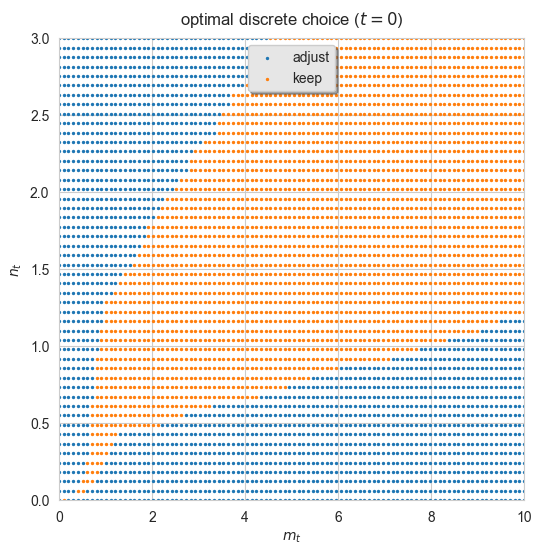

interactive(children=(Dropdown(description='t', options=(0, 1, 2, 3, 4), value=0), Dropdown(description='name'…

In [13]:
### Let's plot
decision_function(DurableReplication)

Yayy, three times the same pictures!

# 4. Comparison with `IndShockConsumerType`
After we established that the new function does exactly the same as in Druedahl (2021), let's focus on the type itself. First, we compare it with the `IndShockConsumerType` in HARK.

With `alpha = 1`, the consumer derives only utility from the non-durable goods they consume. Hence, the problem boils down to exactly the same for the `IndShockConsumerType`.

In [14]:
#### For Comparison, define parameters for the IndShockConsumerType
init_indshock = dict(
    init_idiosyncratic_shocks,
    **{
        ### No income shocks
        "PermGroFac": [1.0],
        "PermShkCount": 7,
        "PermShkStd": [0.0],
        "TranShkStd": [0.0],
        "UnempPrb": 0.0,
        "UnempPrbRet": 0.0,
        "LivPrb": [1.0],
        ### Others
        "BoroCnstArt": 0,
        "BoroCnstdNrm": 0, # Borrowing Constraint of durable goods.
        "cycles": 1,
        "T_cycle": 1,
        "tol": 1e-08,
    }
)

init_durable = dict(
    init_idiosyncratic_shocks,
    **{
        "alpha": 1.0, # Cobb-Douglas parameter for non-durable good consumption in utility function
        "dDepr": 1, # Depreciation Rate of Durable Stock
        "adjC": 0, # Adjustment costs
        "d_ubar": 0, # Minimum durable stock for utility function
        ### No income shocks
        "PermGroFac": [1.0],
        "PermShkCount": 7,
        "PermShkStd": [0.0],
        "TranShkStd": [0.0],
        "UnempPrb": 0.0,
        "UnempPrbRet": 0.0,
        "LivPrb": [1.0],
        # For Grids
        "nNrmMin": 0.0,
        "nNrmMax": 3, #5,
        "nNrmCount": 5, #100,
        "mNrmMin": 0.0,
        "mNrmMax": 10,
        "mNrmCount": 100,
        "xNrmMin": 0.0,
        "xNrmMax": 13, #10,  # xMax = mNrmMax + (1 - adjC)* nNrmMax
        "xNrmCount": 100,
        "aNrmMin": 0.0,
        "aNrmMax": 11,  #xNrmMax+1.0
        "aNrmCount": 100,
        ### For simulation
        "T_sim": 100,
        "AgentCount": 1000,
        ### Others
        "BoroCnstArt": 0,
        "BoroCnstdNrm": 0, # Borrowing Constraint of durable goods.
        "cycles": 1,
        "T_cycle": 1,
        "tol": 1e-08,
        # To construct grids differently
        "NestFac": 3, 
        "grid_type": 'nonlinear',
    }
)

In [15]:
### Define A function which calculates consumption, value and adjusting function. This will come handy later.


def Graphfunctions(AgentType, grid, n):
    grid_x = (1 - AgentType.adjC)*n + grid
    # Consumption Functions
    cFunc_test = np.zeros(len(grid))
    dFunc_test = np.zeros(len(grid))
    exFunc_test = np.zeros(len(grid))
    cFuncKeep_test = np.zeros(len(grid))
    dFuncKeep_test = np.zeros(len(grid))
    exFuncKeep_test = np.zeros(len(grid))
    cFuncAdj_test = np.zeros(len(grid))
    dFuncAdj_test = np.zeros(len(grid))
    exFuncAdj_test = np.zeros(len(grid))
    
    # Value Functions
    vFunc_test = np.zeros(len(grid))
    vFuncKeep_test = np.zeros(len(grid))
    vFuncAdj_test = np.zeros(len(grid))
   
    # Adjuster Function
    adjusting = np.zeros(len(grid))

    for i in range(len(grid)):
        cFunc_test[i] = AgentType.solution[0].cFunc(n,grid[i])
        dFunc_test[i] = AgentType.solution[0].dFunc(n,grid[i])
        exFunc_test[i] = AgentType.solution[0].exFunc(n,grid[i])
        cFuncKeep_test[i] = AgentType.solution[0].cFuncKeep(n,grid[i])
        dFuncKeep_test[i] = AgentType.solution[0].dFuncKeep(n,grid[i])
        exFuncKeep_test[i] = AgentType.solution[0].exFuncKeep(n,grid[i])
        cFuncAdj_test[i] = AgentType.solution[0].cFuncAdj(grid_x[i])
        dFuncAdj_test[i] = AgentType.solution[0].dFuncAdj(grid_x[i])
        exFuncAdj_test[i] = AgentType.solution[0].exFuncAdj(grid_x[i])
        # Value Functions
        vFunc_test[i] = AgentType.solution[0].vFunc(n,grid[i])
        vFuncKeep_test[i] = AgentType.solution[0].vFuncKeep(n,grid[i])
        vFuncAdj_test[i] = AgentType.solution[0].vFuncAdj(grid_x[i])
        adjusting[i] = AgentType.solution[0].adjusting(n,grid[i])
    
    return {"cFunc_test": cFunc_test,
            "dFunc_test": dFunc_test, 
            "exFunc_test": exFunc_test,
            "cFuncKeep_test": cFuncKeep_test,
            "dFuncKeep_test": dFuncKeep_test, 
            "exFuncKeep_test": exFuncKeep_test, 
            "cFuncAdj_test": cFuncAdj_test,
            "dFuncAdj_test": dFuncAdj_test, 
            "exFuncAdj_test": exFuncAdj_test, 
            "vFunc_test": vFunc_test,
            "vFuncKeep_test":vFuncKeep_test,
            "vFuncAdj_test":vFuncAdj_test,
            "adjusting":adjusting,}

In [16]:
### Solve IndShockConsumerType: Lifecycle
IndShockExample_life = IndShockConsumerType(**init_indshock)
IndShockExample_life.cycles = 1
IndShockExample_life.update_income_process()
IndShockExample_life.solve()#(verbose=False)

grid = np.linspace(0,10,100)
cFunc_IndShock_life = np.zeros(len(grid))
for i in range(len(grid)):
    cFunc_IndShock_life[i] = IndShockExample_life.solution[0].cFunc(grid[i])

In [17]:
### Solve IndShockConsumerType: Infinite Horizon
IndShockExample_inf = IndShockConsumerType(**init_indshock)
IndShockExample_inf.cycles = 0
IndShockExample_inf.update_income_process()
IndShockExample_inf.solve()#(verbose=False)

grid = np.linspace(0,10,100)
cFunc_IndShock_inf = np.zeros(len(grid))
for i in range(len(grid)):
    cFunc_IndShock_inf[i] = IndShockExample_inf.solution[0].cFunc(grid[i])

GPFRaw                 = 0.994384 
GPFNrm                 = 0.994384 
GPFAggLivPrb           = 0.994384 
Thorn = APF            = 0.994384 
PermGroFacAdj          = 1.000000 
uInvEpShkuInv          = 1.000000 
VAF                    = 0.960000 
WRPF                   = 0.000000 
DiscFacGPFNrmMax       = 0.970874 
DiscFacGPFAggLivPrbMax = 0.970874 


In [18]:
### Solve DurableConsumerType: Lifecycle
DurableExample_life = DurableConsumerType(**init_durable)
DurableExample_life.alpha = 1.0
DurableExample_life.adjC = 1.0
DurableExample_life.dDepr = 1.0
DurableExample_life.xNrmMax = 13
DurableExample_life.mNrmMax = 13
DurableExample_life.cycles = 1
DurableExample_life.update_income_process()
DurableExample_life.solve()#(verbose=False)
n = 0
Results_life = Graphfunctions(DurableExample_life,grid,n)

In [19]:
### Solve DurableConsumerType: Infinite Horizon

start = time.time()

DurableExample_inf = DurableConsumerType(**init_durable)
DurableExample_inf.alpha = 1.0
DurableExample_inf.adjC = 1.0
DurableExample_inf.dDepr = 1.0
DurableExample_inf.xNrmMax = 13
DurableExample_inf.mNrmMax = 13
DurableExample_inf.nNrmCount = 3
DurableExample_inf.cycles = 0
DurableExample_inf.update_income_process()
DurableExample_inf.solve()#(verbose=False)
Results_inf = Graphfunctions(DurableExample_inf,grid,n)

end = time.time()
time_used_1 = end - start
print("time used: ", time_used_1, " seconds")
### How long did it take to converge?
print(DurableExample_inf.completed_cycles)

time used:  55.88113760948181  seconds
193


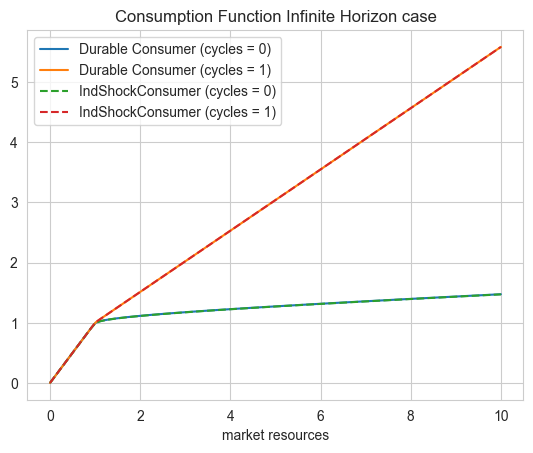

In [20]:
plt.plot(grid, Results_inf['cFunc_test'], label = "Durable Consumer (cycles = 0)")
plt.plot(grid, Results_life['cFunc_test'], label = "Durable Consumer (cycles = 1)")
plt.plot(grid, cFunc_IndShock_inf, '--' , label = "IndShockConsumer (cycles = 0)")
plt.plot(grid, cFunc_IndShock_life, '--' , label = "IndShockConsumer (cycles = 1)")
plt.title('Consumption Function Infinite Horizon case')
plt.xlabel('market resources')
plt.legend()
plt.show()

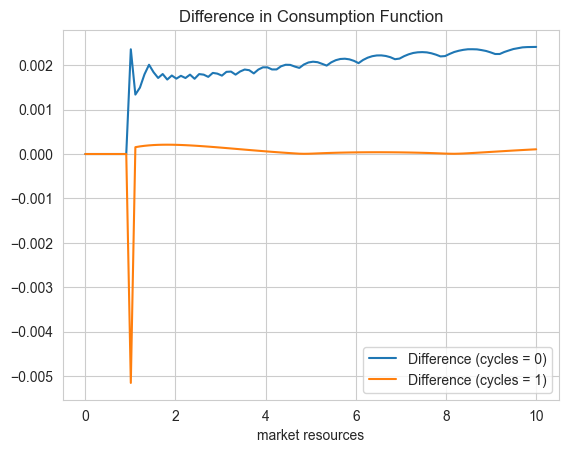

In [21]:
plt.plot(grid, Results_inf['cFunc_test'] - cFunc_IndShock_inf, label = "Difference (cycles = 0)")
plt.plot(grid, Results_life['cFunc_test'] - cFunc_IndShock_life, label = "Difference (cycles = 1)")
plt.title('Difference in Consumption Function')
plt.xlabel('market resources')
plt.legend()
plt.show()

Indeed, it is (almost) exactly the same!

# 5. Bottleneck
### 5a) Two Non-Durable Good Example
As great as the code is, there are still some (minor) problems. For instance, let's take the case when depreciation is 1 and we derive as much utility from good 1 as we do from good 2 (alpha = 0.5). The agent should consume exactly the same for both goods. Let's see how it works:

In [22]:
TwoGoodExample = DurableConsumerType(**init_durable)
TwoGoodExample.alpha = 0.5
TwoGoodExample.dDepr = 1
TwoGoodExample.adjC = 1
TwoGoodExample.nNrmCount = 50
TwoGoodExample.update()
TwoGoodExample.update_income_process()
TwoGoodExample.solve()#(verbose=False)

Consumption function for an idiosyncratic shocks consumer type with durable stock = 0 alpha 0.5 , and Adjustment Costs 1


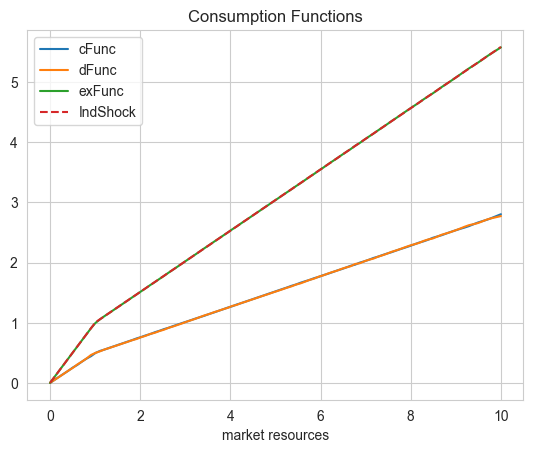

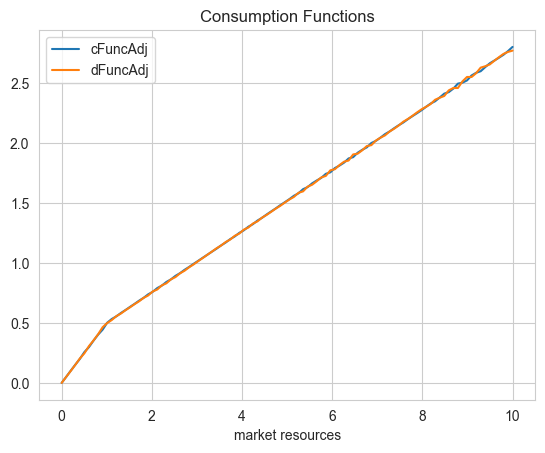

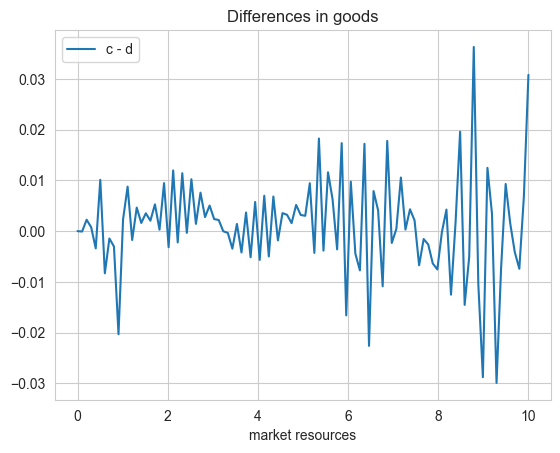

In [23]:
n = 0
print('Consumption function for an idiosyncratic shocks consumer type with durable stock =', n, 'alpha', TwoGoodExample.alpha, ', and Adjustment Costs', TwoGoodExample.adjC)
Results = Graphfunctions(TwoGoodExample,grid,n)

plt.plot(grid, Results['cFunc_test'], label = "cFunc")
plt.plot(grid, Results['dFunc_test'], label = "dFunc")
plt.plot(grid, Results['exFunc_test'], label = "exFunc")
plt.plot(grid,cFunc_IndShock_life, '--', label = "IndShock")
plt.title('Consumption Functions')
plt.xlabel('market resources')
plt.legend()
plt.show()

plt.plot(grid, (Results['cFuncAdj_test']), label = "cFuncAdj")
plt.plot(grid, (Results['dFuncAdj_test']), label = "dFuncAdj")
plt.title('Consumption Functions')
plt.xlabel('market resources')
plt.legend()
plt.show()

plt.plot(grid, Results['cFuncAdj_test'] - Results['dFuncAdj_test'], label = "c - d")
plt.title('Differences in goods')
plt.xlabel('market resources')
plt.legend()
plt.show()

ALAS poor DurableConsumerType!

While the total expenditure function is still the same, we consume slightly different quantities of both goods! Is this a bug or a feature of the code?

To check this, let's see if the utility function is actually higher if c = d

<ipython-input-24-401ecac66feb>:4: RuntimeWarning: divide by zero encountered in reciprocal
  u_new = ((c_new**TwoGoodExample.alpha * d_new**(1 - TwoGoodExample.alpha))/(1 - TwoGoodExample.CRRA))**(1 - TwoGoodExample.CRRA)
<ipython-input-24-401ecac66feb>:5: RuntimeWarning: divide by zero encountered in reciprocal
  u_old = ((Results['cFuncAdj_test']**TwoGoodExample.alpha * Results['dFuncAdj_test']**(1 - TwoGoodExample.alpha))/(1 - TwoGoodExample.CRRA))**(1 - TwoGoodExample.CRRA)


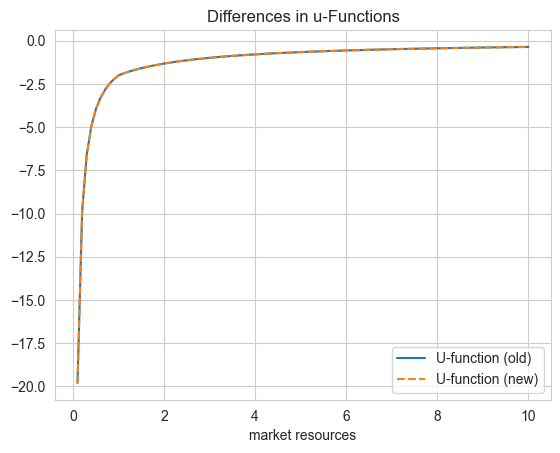

<ipython-input-24-401ecac66feb>:18: RuntimeWarning: invalid value encountered in subtract
  plt.plot(grid, u_old - u_new, label = "Differences in u-function")


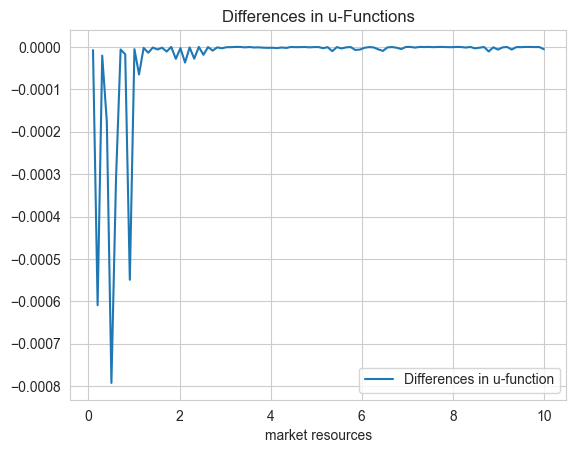

In [24]:
# create c_new and d_new which are exactly the same
c_new = (Results['cFuncAdj_test'] + Results['dFuncAdj_test'])/ 2
d_new = c_new
u_new = ((c_new**TwoGoodExample.alpha * d_new**(1 - TwoGoodExample.alpha))/(1 - TwoGoodExample.CRRA))**(1 - TwoGoodExample.CRRA)
u_old = ((Results['cFuncAdj_test']**TwoGoodExample.alpha * Results['dFuncAdj_test']**(1 - TwoGoodExample.alpha))/(1 - TwoGoodExample.CRRA))**(1 - TwoGoodExample.CRRA)

v_new = - 1/u_new
v_old = - 1/u_old

# plt.plot(grid, u_old - u_new, label = "Differences in u-function")
plt.plot(grid, u_old, label = "U-function (old)")
plt.plot(grid, u_new, '--', label = "U-function (new)")
plt.title('Differences in u-Functions')
plt.xlabel('market resources')
plt.legend()
plt.show()

plt.plot(grid, u_old - u_new, label = "Differences in u-function")
plt.title('Differences in u-Functions')
plt.xlabel('market resources')
plt.legend()
plt.show()

### Result: utility if c = d is higher than what we get using the solution!

## 5b) Adding Shocks
What happens if we include uncertainty? Does the solution stays close or do we see a convergence?

### i) Permanent Shocks

In [25]:
### Solve IndShockConsumerType: Lifecycle
IndShockExample_life_perm = IndShockConsumerType(**init_indshock)
IndShockExample_life_perm.PermShkStd = [0.06]
IndShockExample_life_perm.update_income_process()
IndShockExample_life_perm.solve()#(verbose=False)

grid = np.linspace(0,10,100)
cFunc_IndShock_life_perm = np.zeros(len(grid))
for i in range(len(grid)):
    cFunc_IndShock_life_perm[i] = IndShockExample_life_perm.solution[0].cFunc(grid[i])

In [26]:
### Solve IndShockConsumerType: Infinite Horizon
IndShockExample_inf_perm = IndShockConsumerType(**init_indshock)
IndShockExample_inf_perm.cycles = 0
IndShockExample_inf_perm.PermShkStd = [0.06]
IndShockExample_inf_perm.update_income_process()
IndShockExample_inf_perm.solve()#(verbose=False)

grid = np.linspace(0,10,100)
cFunc_IndShock_inf_perm = np.zeros(len(grid))
for i in range(len(grid)):
    cFunc_IndShock_inf_perm[i] = IndShockExample_inf_perm.solution[0].cFunc(grid[i])

GPFRaw                 = 0.994384 
GPFNrm                 = 0.997734 
GPFAggLivPrb           = 0.994384 
Thorn = APF            = 0.994384 
PermGroFacAdj          = 0.996642 
uInvEpShkuInv          = 0.996642 
VAF                    = 0.956777 
WRPF                   = 0.000000 
DiscFacGPFNrmMax       = 0.964365 
DiscFacGPFAggLivPrbMax = 0.970874 


In [27]:
### Solve DurableConsumerType: Lifecycle
DurableExample_life_perm = DurableConsumerType(**init_durable)
DurableExample_life_perm.PermShkStd = [0.06]
DurableExample_life_perm.nNrmCount = 3 # To increase speed
DurableExample_life_perm.update_income_process()
DurableExample_life_perm.solve()#(verbose=False)
n = 0
Results_life_perm = Graphfunctions(DurableExample_life_perm,grid,n)

In [ ]:
### Solve DurableConsumerType: Infinite Horizon
DurableExample_inf_perm = DurableConsumerType(**init_durable)
DurableExample_inf_perm.cycles = 0
DurableExample_inf_perm.PermShkStd = [0.06]
DurableExample_inf_perm.nNrmCount = 3 # To increase speed
DurableExample_inf_perm.update_income_process()
DurableExample_inf_perm.solve()#(verbose=False)
n = 0
Results_inf_perm = Graphfunctions(DurableExample_inf_perm,grid,n)

In [ ]:
plt.plot(grid, Results_inf_perm['cFunc_test'], label = "Durable Consumer (cycles = 0)")
plt.plot(grid, Results_life_perm['cFunc_test'], label = "Durable Consumer (cycles = 1)")
plt.plot(grid, cFunc_IndShock_inf_perm, '--' , label = "IndShockConsumer (cycles = 0)")
plt.plot(grid, cFunc_IndShock_life_perm, '--' , label = "IndShockConsumer (cycles = 1)")
plt.title('Consumption Functions: Permanent Shocks')
plt.xlabel('market resources')
plt.legend()
plt.show()

plt.plot(grid, Results_inf_perm['cFunc_test'] - cFunc_IndShock_inf_perm, label = "Difference (cycles = 0)")
plt.plot(grid, Results_life_perm['cFunc_test'] - cFunc_IndShock_life_perm, label = "Difference (cycles = 1)")
plt.title('Difference in Consumption Function')
plt.xlabel('market resources')
plt.legend()
plt.show()

### ii) Transitory Shocks

In [ ]:
### Solve IndShockConsumerType: Lifecycle
IndShockExample_life_tran = IndShockConsumerType(**init_indshock)
IndShockExample_life_tran.TranShkStd = [0.06]
IndShockExample_life_tran.update_income_process()
IndShockExample_life_tran.solve()#(verbose=False)

grid = np.linspace(0,10,100)
cFunc_IndShock_life_tran = np.zeros(len(grid))
for i in range(len(grid)):
    cFunc_IndShock_life_tran[i] = IndShockExample_life_tran.solution[0].cFunc(grid[i])

In [ ]:
### Solve IndShockConsumerType: Infinite Horizon
IndShockExample_inf_tran = IndShockConsumerType(**init_indshock)
IndShockExample_inf_tran.cycles = 0
IndShockExample_inf_tran.TranShkStd = [0.06]
IndShockExample_inf_tran.update_income_process()
IndShockExample_inf_tran.solve()#(verbose=False)

grid = np.linspace(0,10,100)
cFunc_IndShock_inf_tran = np.zeros(len(grid))
for i in range(len(grid)):
    cFunc_IndShock_inf_tran[i] = IndShockExample_inf_tran.solution[0].cFunc(grid[i])

In [ ]:
### Solve DurableConsumerType: Lifecycle
DurableExample_life_tran = DurableConsumerType(**init_durable)
DurableExample_life_tran.TranShkStd = [0.06]
DurableExample_life_tran.nNrmCount = 3 # To increase speed
DurableExample_life_tran.update_income_process()
DurableExample_life_tran.solve()#(verbose=False)
n = 0
Results_life_tran = Graphfunctions(DurableExample_life_tran,grid,n)

In [ ]:
### Solve DurableConsumerType: Infinite Horizon
DurableExample_inf_tran = DurableConsumerType(**init_durable)
DurableExample_inf_tran.cycles = 0
DurableExample_inf_tran.TranShkStd = [0.06]
DurableExample_inf_tran.nNrmCount = 3 # To increase speed
DurableExample_inf_tran.update_income_process()
DurableExample_inf_tran.solve()#(verbose=False)
n = 0
Results_inf_tran = Graphfunctions(DurableExample_inf_tran,grid,n)

In [ ]:
plt.plot(grid, Results_inf_tran['cFunc_test'], label = "Durable Consumer (cycles = 0)")
plt.plot(grid, Results_life_tran['cFunc_test'], label = "Durable Consumer (cycles = 1)")
plt.plot(grid, cFunc_IndShock_inf_tran, '--' , label = "IndShockConsumer (cycles = 0)")
plt.plot(grid, cFunc_IndShock_life_tran, '--' , label = "IndShockConsumer (cycles = 1)")
plt.title('Consumption Functions: Transitory Shocks')
plt.xlabel('market resources')
plt.legend()
plt.show()

In [ ]:
plt.plot(grid, Results_inf_tran['cFunc_test'] - cFunc_IndShock_inf_tran, label = "Difference (cycles = 0)")
plt.plot(grid, Results_life_tran['cFunc_test'] - cFunc_IndShock_life_tran, label = "Difference (cycles = 1)")
plt.title('Difference in Consumption Function')
plt.xlabel('market resources')
plt.legend()
plt.show()

### Result:
Uncertainty creates a small wedge between the two types. Especially using perment shocks and an infinite horizon model could lead to problems. Keep this in mind when using the solver!